# 6章：機械学習の適用による予兆検知（Amazon SageMaker）

ここでは、[NASA Bearing Datasetのデータ](https://www.nasa.gov/intelligent-systems-division/discovery-and-systems-health/pcoe/pcoe-data-set-repository/)を利用して、教師なし異常検知モデルを構築します。\
上記、リンクからダウンロードし、本の内容に従ってご自身のAWSアカウントのS3上にデータを配置ください。

## ライブラリのインストールと読み込み

必要なpythonライブラリのインストールとimportを行います。

In [ ]:
!pip install smart-open
!pip install tqdm

import pandas as pd
import numpy as np
import datetime as dt
import csv
import smart_open
from tqdm.notebook import tqdm
import boto3
import sagemaker
from sagemaker import RandomCutForest
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## データ加工

NASA Bearing Datasetのデータ加工を行います。データ加工内容は、時刻情報の追加です。\
`{your bucket name}`にご自身のS3バケット名を入力し、実行します。\
データ量が多いため、実行には数分要します。

In [2]:
bucket_name = "{your bucket name}"
rawdata_prefix_key = "IMS/2nd_test"
csvdata_prefix_key = "csv/2nd_test"

#S3から生データのファイルリストを取得
s3_client = boto3.resource('s3')
bucket = s3_client.Bucket(bucket_name)
response = bucket.meta.client.list_objects_v2(Bucket=bucket.name, Prefix=rawdata_prefix_key)

# 各ファイルでのデータ処理
for obj in tqdm(response['Contents']):
    if obj["Size"] != 0 :
        prefixKey = obj["Key"]
        
        #ファイル名から開始時刻の取得
        filename_format = '%Y.%m.%d.%H.%M.%S'
        target_time = dt.datetime.strptime(prefixKey.split('/')[-1], filename_format)
        
        #出力するcsvファイル名、urlを定義
        csv_filename = prefixKey.split("/")[-1]+'.csv'
        url = "s3://{}/{}/{}".format(bucket_name,csvdata_prefix_key,csv_filename)
        
        #データ処理
        #S3から生データを読み込み、日付を先頭に追加してcsvファイルとしてS3に配置する。
        with smart_open.open(url, 'w', transport_params={'client': boto3.client('s3')}) as fout:
            writer = csv.writer(fout)
            with smart_open.open("s3://{}/{}".format(bucket_name,prefixKey),'rb', transport_params={'client': boto3.client('s3')}) as fin:
                for _line in fin:
                    #ファイル中のレコード読み込み
                    _line = _line.decode().replace('\r\n','').split('\t')

                    #時刻追加
                    _line.insert(0,target_time.strftime('%Y-%m-%d %H:%M:%S.%f'))

                    #レコードの追加
                    writer.writerow(_line)

                    #時間の更新
                    target_time = target_time + dt.timedelta(milliseconds=600000/20480)

  0%|          | 0/984 [00:00<?, ?it/s]

## 学習データの準備

モデルを構築するための学習データを選定し、配置します。最も古いデータである"2004.02.12.10.32.39.csv"のデータを正常データとして学習させるため、学習データとしてpandasのDataframeとして読み込みます。

In [3]:
train_filename = "2004.02.12.10.32.39.csv"
training_prefix_key = 'rcf-model-training'

#学習データの読み込み
train_csv_filepath = "s3://{}/{}/{}".format(bucket_name,csvdata_prefix_key,train_filename)
df_train = pd.read_csv(train_csv_filepath,
                       header=None,
                       names=['datetime','B1','B2','B3','B4'],
                       dtype = {'datetime':'str', 'B1':'float32', 'B2':'float32','B3':'float32','B4':'float32'},
                       parse_dates=['datetime']
        
)
train = df_train[['B1','B2','B3','B4']]

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/fsspec/registry.py:272: UserWarning: Your installed version of s3fs is very old and known to cause
severe performance issues, see also https://github.com/dask/dask/issues/10276

To fix, you should specify a lower version bound on s3fs, or
update the current installation.

  warnings.warn(s3_msg)


s3fsのバージョンが古いというWarningが出力されることがありますが、問題ありません。

## モデル構築

Random Cut Forest(RCF)を用いて教師なし異常検知モデルを構築します。\
学習には数分かかります。

In [ ]:
#学習ジョブ実行のためのセッション取得
session = sagemaker.Session()
execution_role = sagemaker.get_execution_role()

#学習ジョブの設定
rcf = RandomCutForest(role=execution_role,
                      instance_count=1,
                      instance_type='ml.m5.xlarge',
                      data_location='s3://{}/{}/record-set/'.format(bucket_name, training_prefix_key),
                      output_path='s3://{}/{}/output'.format(bucket_name, training_prefix_key),
                      num_samples_per_tree=512,
                      num_trees=100)

#学習ジョブの実行
rcf.fit(rcf.record_set(train.to_numpy(),channel='train', encrypt=False))

#学習ジョブ名の表示
print('Training job name: {}'.format(rcf.latest_training_job.job_name))

## バッチ推論の実行

構築されたモデルを使って、推論を実行します。今回はバッチ変換（推論）を使ってS3上のデータを一気に推論し、結果をS3に出力します。\
推論には10分程度かかります。

In [ ]:
inference_input_location = "s3://{}/{}".format(bucket_name, csvdata_prefix_key)

inference_output_prefix_key = 'rcf-model-inference'
inference_output_location = "s3://{}/{}".format(bucket_name, inference_output_prefix_key)

num_instances = 4
rcf_transformer = rcf.transformer(
                                    instance_count = num_instances, 
                                    instance_type = 'ml.m5.xlarge', 
                                    strategy = "MultiRecord",
                                    assemble_with = 'Line', 
                                    accept = 'text/csv',
                                    output_path = inference_output_location
                                   )

# start a transform job
rcf_transformer.transform(inference_input_location, 
                          split_type='Line', 
                          content_type='text/csv', 
                          join_source='Input',
                          input_filter='$[1:4]'
                         )
rcf_transformer.wait()

## 推論結果の可視化

バッチ変換（推論）により、出力された異常度スコアを可視化します。\
実行には数分かかります。

  0%|          | 0/984 [00:00<?, ?it/s]

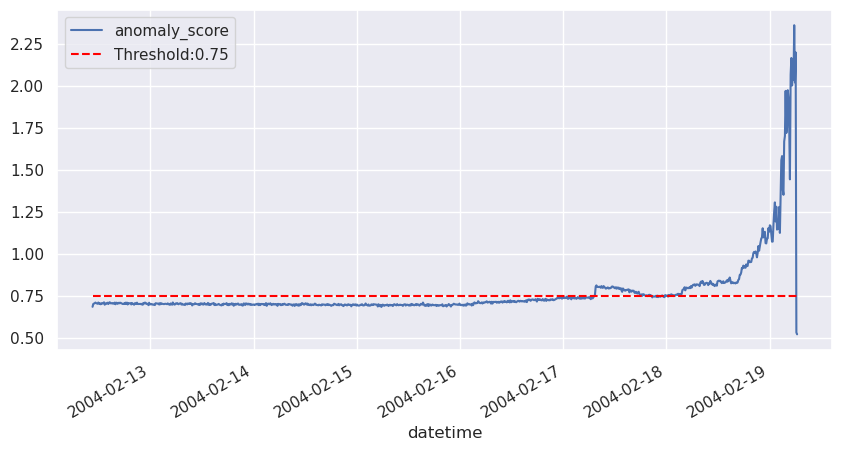

In [9]:
s3_client = boto3.resource('s3')
bucket = s3_client.Bucket(bucket_name)
response = bucket.meta.client.list_objects_v2(Bucket=bucket.name, Prefix=inference_output_prefix_key)

list_anomalyscore = []

# 各ファイルでのデータ処理
for obj in tqdm(response['Contents']):
    if obj["Size"] != 0 :
        prefixKey = obj["Key"]
        _list_records = []
        
        #データ処理
        #S3から推論結果データを読み込み、統計処理を加えて異常度スコアを取得
        for line in smart_open.smart_open("s3://{}/{}".format(bucket_name,prefixKey)):
            _list_line = line.decode().replace('\n','').split(',')
            _list_records.append(_list_line)
            
        #numpyの配列に変換し、0列目のdatetimeの最小値、5列目の異常度スコアの中央値を計算
        _list_array = np.array(_list_records)
        datetime_min = np.min(_list_array[:,0].astype(dt.datetime),axis=0)
        anomaly_score_median = np.median(_list_array[:,5].astype(np.float32),axis=0)

        #各ファイルごとの統計値を取得
        list_anomalyscore.append([datetime_min,anomaly_score_median])
        
#異常度スコアの中央値をグラフ化
df_score = pd.DataFrame(list_anomalyscore, columns=['datetime','anomaly_score'])
df_score['datetime'] = pd.to_datetime(df_score['datetime'])
df_score = df_score.set_index('datetime')

threshold = 0.75
ax = df_score.plot(figsize=(10,5))
ax.hlines([threshold], df_score.index.min(), df_score.index.max(), "red", linestyles='dashed',label="Threshold:"+str(threshold)) 
ax.legend()

閾値0.75とした場合、2004年2月17日に異常検知できたことがわかります。

### EOF